In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
import numpy as np
import nltk

In [15]:
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename,'r')
  #read all text
  text = file.read()
  #close the file
  file.close()
  return text

In [17]:
text = load_doc('drive/MyDrive/review_polarity/txt_sentoken/pos/cv026_29325.txt')
text

'for those of us who weren\'t yet born when the 1960\'s rock \'n\' rolled around , monterey pop affords an affectionate glimpse of the music that influenced our parents to be hippies . \nfrom otis redding to jimi hendrix , janis joplin to the mamas and the papas , and jefferson airplane to the who , this documentary is jam-packed with contagious energy . \nbut i give fair warning that i will reveal the ending , which does not do the rest of the film the justice it deserves . \nshot in 1969 at an outdoor concert that precluded woodstock , the film defies the stereotype of the general population at the time . \nsure , some have painted their faces and smoke joints , but d . a . \npennebaker ( the war room , moon over broadway ) surprisingly chooses to show a broad spectrum of the audience . \nno matter who is watching , it all comes back to the talented musicians that stir your soul . \nthe excitement starts before the music even begins . \na young girl is cleaning thousands of seats and

In [18]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove puctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove reamaning tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [19]:
clean = clean_doc(text)
len(clean)

261

In [20]:
# load_doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return " ".join(tokens)

In [21]:
def process_train(directory, vocab):
  documents = list()
  for filename in listdir(directory):
    if not filename.startswith('cv9'):
      path = directory + '/' + filename
      doc = load_doc(path)
      tokens = doc_to_line(doc, vocab)
      documents.append(tokens)
    return documents

def process_test(directory, vocab):
  documents = list()
  for filename in listdir(directory):
    if filename.startswith('cv9'):
      path = directory + '/' + filename
      doc = load_doc(path)
      tokens = doc_to_line(doc, vocab)
      documents.append(tokens)
    return documents

In [22]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any review in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of file to open
        path  = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc)
        # add to list
        documents.append(tokens)
    return documents

In [23]:
vocab = open('/content/vocab.txt')
vocab = vocab.read().split()

In [24]:
doc_to_line('drive/MyDrive/review_polarity/txt_sentoken/pos/cv026_29325.txt', vocab)

'us werent yet born rock rolled around monterey pop affectionate glimpse music influenced parents hippies otis redding jimi hendrix janis joplin mamas papas jefferson airplane documentary jampacked contagious energy give fair warning reveal ending rest film justice deserves shot outdoor concert film defies stereotype general population time sure painted faces smoke joints war room moon broadway surprisingly chooses show broad spectrum audience matter watching comes back talented musicians stir soul excitement starts music even begins young girl cleaning thousands seats asked interviewer replies feels lucky moments organized craziness john phillips leader mamas papas one concert tries get touch one band tuning member remarks finally decent sound system tell watching first moments show isnt vanity playing music love appreciation street interaction audience performer continues throughout film becomes infectious audience impossible tear eyes away janis joplin belts ballad love ball chain l

In [25]:
lines = process_docs('drive/MyDrive/review_polarity/txt_sentoken/pos', vocab, True)
len(lines)

900

In [26]:
lines = process_docs('drive/MyDrive/review_polarity/txt_sentoken/pos', vocab, False)
len(lines)

100

In [27]:
# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('drive/MyDrive/review_polarity/txt_sentoken/neg', vocab, is_train)
    pos = process_docs('drive/MyDrive/review_polarity/txt_sentoken/pos', vocab, is_train)

    docs = neg + pos
    #prepare lables
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

In [28]:
train, train_labels = load_clean_dataset(vocab, True)
test, test_labels = load_clean_dataset(vocab, False)

len(train), len(train_labels),len(test), len(test_labels)

(1810, 1810, 200, 200)

In [29]:
from keras.models import Sequential
from keras.layers import Dense

In [30]:
# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape = (n_words,), activation = 'relu'))
  model.add(Dense(1,  activation = 'sigmoid'))
  # compile network
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  # summerize defined model
  model.summary()
  plot_model(model, to_file='model.png',show_shapes=True)
  return model

In [31]:
define_model(100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5101 (19.93 KB)
Trainable params: 5101 (19.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [33]:
# create the tokenizer
tokenizer = create_tokenizer(train)

In [34]:
# enocde data
x_train = tokenizer.texts_to_matrix(train, mode = 'binary')
x_train.shape

(1810, 44277)

In [35]:
x_test = tokenizer.texts_to_matrix(test, mode = 'binary')
x_test.shape

(200, 44277)

In [36]:
tokenizer.word_docs

defaultdict(int,
            {'ask': 116,
             'depraved': 5,
             'finally': 262,
             'enmeshed': 1,
             'goes': 473,
             'covering': 23,
             'forever': 76,
             'horror': 192,
             'big': 549,
             'need': 236,
             'vision': 56,
             'something': 650,
             'wholesome': 11,
             'joel': 43,
             'sordid': 10,
             'matteroffactly': 2,
             'particularly': 206,
             'along': 399,
             'condemn': 5,
             'offensive': 52,
             'interesting': 430,
             'even': 1163,
             'cover': 76,
             'drags': 38,
             'beneath': 29,
             'unsavory': 4,
             'eyes': 207,
             'fairly': 110,
             'bigtown': 1,
             'films': 944,
             'ways': 153,
             'private': 89,
             'phoenix': 13,
             'making': 418,
             'condone': 5,
      

In [37]:
# define network
n_words = x_train.shape[1]
model = define_model(n_words)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                2213900   
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2213951 (8.45 MB)
Trainable params: 2213951 (8.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model.fit(x_train, np.array(train_labels), epochs = 10, batch_size=5)

Epoch 1/10
362/362 [==============================] - 3s 3ms/step - loss: 0.4223 - accuracy: 0.7994
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9967
Epoch 3/10
362/362 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 4/10
362/362 [==============================] - 2s 4ms/step - loss: 9.6478e-04 - accuracy: 1.0000
Epoch 5/10
362/362 [==============================] - 1s 4ms/step - loss: 3.8530e-04 - accuracy: 1.0000
Epoch 6/10
362/362 [==============================] - 1s 4ms/step - loss: 2.0071e-04 - accuracy: 1.0000
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 1.2303e-04 - accuracy: 1.0000
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 8.0805e-05 - accuracy: 1.0000
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 5.5683e-05 - accuracy: 1.0000
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 3

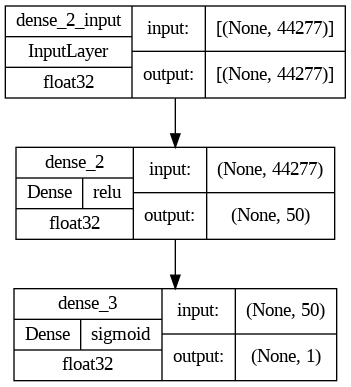

In [39]:
plot_model(model, show_dtype=True, show_layer_activations = True, show_shapes = True, show_layer_names=True)

In [40]:
model.evaluate(x_test,np.array(test_labels), batch_size=1)

200/200 [==============================] - 1s 2ms/step - loss: 0.2460 - accuracy: 0.9100


[0.24600547552108765, 0.9100000262260437]

In [78]:
text1 = 'Best movie ever! It was great, I will definitely recommend it.'
text2 = 'This is a bad movie.'
text3 = 'This is a best movie'
text4 = 'The acting was bad in this movie'

In [63]:
x_test = tokenizer.texts_to_matrix(test, mode = 'binary')
x_test.shape

(200, 44277)

In [71]:
def predict(text):
  tokens = clean_doc(text)
  text = " ".join(tokens)
  x_test = tokenizer.texts_to_matrix([text], mode = 'binary')
  prediction = model.predict(x_test)
  if prediction >= 0.5:
    return 'Positive'
  else:
     return 'Negative'


In [72]:
predict(text1)

1/1 [==============================] - 0s 25ms/step


'Positive'

In [73]:
predict(text2)

1/1 [==============================] - 0s 19ms/step


'Negative'

In [79]:
predict(text3)

1/1 [==============================] - 0s 18ms/step


'Positive'

In [75]:
predict(text4)

1/1 [==============================] - 0s 28ms/step


'Negative'

In [80]:
# classify a review a negative or positive
def predict_sentiment(review):
  #clean
  tokens = clean_doc(review)
  # Convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode = 'binary')
  # predict sentiment
  yhat = model.predict(encoded, verbose=0)
  # retrieve predicted percentage and lable
  percent_pos = yhat[0 ,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, "POSITIVE"

In [ ]:
percent, sentiment = predict_sentiment(text1)
print('Review: [%s]\n Sentiment: %s (%.3f%%)' % (text1, sentiment, percent))

Review: [%s]
 Sentiment: &s (%.3f%%) Best movie ever! It was great, I will definitely recommend it. POSITIVE 0.72520405


In [82]:
percent, sentiment = predict_sentiment(text2)
print(f'Review: [{text1}]\n Sentiment: {sentiment} ({percent:.3f}%)')

(0.6657558083534241, 'NEGATIVE')

In [83]:
predict_sentiment(text3)

(0.5419083, 'POSITIVE')

In [84]:
predict_sentiment(text4)

(0.7179630398750305, 'NEGATIVE')